notes: 
- best cross exc range ~0.012,0.018 (results in up to 53% resp) 
- high intra rsrs will throw off resp to bic
- cross rsrs = 0.02 -> 0.0155 (clear single cell patterns for spiky cells but drops population resp) 
- cross rsfs = 0.3 -> 0.255
- paired resp shaky, jitter not increasing for paired bic plots wrt IDI
> increase in jitter to PW deflection with IDI is due to the fact that as IDI increases, net excitation spans a longer time interval (in the absence of GABA, jitter is generally higher due to the lack of inhibition to curtail the temporal window within which the RS cell can respond to TC excitation)
- ^ so should RSRS should be more due to longer route (more chance for variation)? 
- ~2.5-3 ms delay in paired surpression compared to TC cross synapses model


to do: 
- check surpression for non pref directions, might have better resp -> more consistent surpression 
> many angular directions of AW deflection are capable of suppressing the re- sponse to subsequent PW deflection, and the AW deflection direction which yields maximal suppression can vary from RS cell to RS cell (even for RS cells with the same preferred PW direction)
- check average direction prefs, correlation, inhibition/PW resp
- bursting exc dynamics
- double check latency calculations/implementation (should be 1.9 onset 4.some peak)
- ^ latency inc when exc str increases, could also fix paired jitter
- figure out how to integrate AW inputs when adding 3rd barrel

In [2]:
import numpy as np
import math
from scipy import stats

# initialize
numdir = 8              # dir groups inc by increments of 45
numTC  = 30             # 240 total TC cells, 8 direction groups 30 cells each
numRS  = 20             # 160 total RS cells, 8 direction groups 20 cells each
numFS  = 100            # 100 FS cells no direction selectivity 
tRS = numdir * numRS          # total RS cells
tTC = numdir * numTC          # total TC cells
tcells = (tTC + tRS + numFS)  # total cells

# spike probs
tcfsP = 0.65
fsfsP = 0.5
fsrsP = 1
rsrsP = 1     # all to all connectivity

# TC->RS spike prob by direction difference, 0.35 avg
tcrs0 = 0.7   # 0
tcrs1 = 0.5   # 45
tcrs2 = 0.3   # 90
tcrs3 = 0.15  # 135
tcrs4 = 0.1   # 180

# synaptic delay
tcfsSD = 0
tcrsSD = 0
fsfsSD = 0
fsrsSD = 3
rsrsSD = 2

# amplitudes
fsfsA = 0.1
fsrsA = 0.03
tcfsA = 0.3
tcrsA = 0.04 #0.06
rsrsA = 0 # 0.008

# decay rates
tcfsD = 0.73
tcrsD = 0.75
fsfsD = 0.18
fsrsD = 0.18
rsrsD = 0.24

# TC spike prob by direction difference
tcsp0 = 0.8   # 0
tcsp1 = 0.7   # 45
tcsp2 = 0.4   # 90
tcsp3 = 0.15  # 135
tcsp4 = 0.1   # 180

# adjacent whisker spike probs

# rsrsAW = .7
# rsfsAW = .4

# rsrsSDA = 2
# rsfsSDA = 2

# rsfsD = fsrsD
# rsrsAA = 0.0055
# rsfsAA = 0.16

rsrsAW = .7
rsfsAW = .4

rsrsSDA = 2
rsfsSDA = 2

rsfsD = fsrsD
rsrsAA = 0.006
rsfsAA = 0.08

In [3]:
# parameters
trials = 10
ETIME  = 25.0                 # length of simulation (ms)
TSTEP  = 0.1 # 0.01                 # time step of computation
NSTEPS = int((ETIME/TSTEP)+1) # number of computational steps 
ASIZE  = int(NSTEPS+1)        # array size variable

g_L     = 0.05                # leak conductance
V_rest  = 0                   # resting potential
tau_m   = 20                  # time constant (ms)
tau_ref = 2                   # refractory period (ms)
refsteps  = tau_ref/TSTEP     # refractory period in time steps
threshold = 1                
maxspikes = 15

PLOTFS = 4                 # PW FS cell number to plot and print statistics for
PLOTRS = 4                 # PW RS cell number to plot and print statistics for
PLOTFSA = 24                 # AW FS cell number to plot and print statistics for
PLOTRSA = 31                 # AW RS cell number to plot and print statistics for
defdir = 4
defdirA = 2
groupav = 1

# simulate velocities by changing TCsd
TCmean = 8   # mean of TC spike time distribution (ms)
# TCmeanA = 10   # mean of TC spike time distribution (ms)
IDI = 8       # interdeflection interval
TCsd   = 1    # stdev of TC spike time dist: from high to low velocity, 1,1.25,1.5,2,2.5,3 ms

In [5]:
tune = np.zeros((numdir,tRS),dtype=float)
allavg = np.zeros((numdir,tRS),dtype=float)

SetCoupling(coupling,22)
SetCoupling(couplingA,44)
CrossCoupling(couplingC,66)

tunetotal = 0
tuning = []

for y in range(0,6): 

    rsrsAW = .05*y + .55 #.5 to .8
    print('RSRS connection prob:',rsrsAW)

    
    sp0=[]
    sp0A=[]

    RSresp = []
    RSrespA = []

    RSa = 0
    RSaA = 0

    RStune = []
    RStuneA = []

    for z in range(1,numdir+1): 

        defdir = z

        # initialize storage arrays
        tctimes   = np.zeros((tTC))                         # store spike times of each TC cell
        tctimesA  = np.zeros((tTC))
        time      = np.zeros((ASIZE,))

        fsvolt  = np.zeros((numFS,ASIZE))
        fsexc   = np.zeros((numFS,ASIZE))
        fsinh   = np.zeros((numFS,ASIZE))         
        rsvolt  = np.zeros((tRS,ASIZE))
        rsinh   = np.zeros((tRS,ASIZE))
        rsexc   = np.zeros((tRS,ASIZE))
        tcrsexc = np.zeros((tRS,ASIZE))
        rsrsexc = np.zeros((tRS,ASIZE))

        fsvoltA  = np.zeros((numFS,ASIZE))
        fsexcA   = np.zeros((numFS,ASIZE))
        fsinhA   = np.zeros((numFS,ASIZE))         
        rsvoltA  = np.zeros((tRS,ASIZE))
        rsinhA   = np.zeros((tRS,ASIZE))
        rsexcA   = np.zeros((tRS,ASIZE))
        tcrsexcA = np.zeros((tRS,ASIZE))
        rsrsexcA = np.zeros((tRS,ASIZE))

        # temporary storage variables (V, exc, inh) 
        fsv   = np.zeros((numFS,2))
        fse   = np.zeros((numFS,2))
        fsi   = np.zeros((numFS,2))
        rsv   = np.zeros((tRS,2))
        rsi   = np.zeros((tRS,2))
        rse   = np.zeros((tRS,2))
        tcrse = np.zeros((tRS,2))
        rsrse = np.zeros((tRS,2))

        # temporary storage variables (V, exc, inh) for 2nd barrel
        fsvA   = np.zeros((numFS,2))
        fseA   = np.zeros((numFS,2))
        fsiA   = np.zeros((numFS,2))
        rsvA   = np.zeros((tRS,2))
        rsiA   = np.zeros((tRS,2))
        rseA   = np.zeros((tRS,2))       # rscross
        tcrseA = np.zeros((tRS,2))
        rsrseA = np.zeros((tRS,2))

        # track refractory periods for each neuron
        fsref = np.zeros((numFS,))
        rsref = np.zeros((tRS,))
        fsrefA = np.zeros((numFS,))
        rsrefA = np.zeros((tRS,))

        # track of spike counts of each neuron (all trials)
        fsspikecount  = np.zeros((trials,numFS),dtype=int)
        rsspikecount  = np.zeros((trials,tRS),dtype=int)

        fsspikecountA  = np.zeros((trials,numFS),dtype=int)
        rsspikecountA  = np.zeros((trials,tRS),dtype=int)  

        # keep track of how many spikes have been inputed
        fsspiketrack  = np.zeros((numFS,),dtype=int)
        fsspiketrack2 = np.zeros((numFS,),dtype=int) 
        rsspiketrack  = np.zeros((tRS,),dtype=int) 

        fsspiketrackA  = np.zeros((numFS,),dtype=int)
        fsspiketrack2A = np.zeros((numFS,),dtype=int) 
        rsspiketrackA  = np.zeros((tRS,),dtype=int) 

        # track spike times of each neuron (all trials)
        fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
        rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

        fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
        rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

        # 
        tempexc = np.zeros((ASIZE,))
        tempinh = np.zeros((ASIZE,))
        tempsyn = np.zeros((ASIZE,))

        tempexcA = np.zeros((ASIZE,))
        tempinhA = np.zeros((ASIZE,))
        tempsynA = np.zeros((ASIZE,))

        for trial in range(1, trials+1):
            tctimes  = np.zeros((tTC))
            tctimesA  = np.zeros((tTC))
            setTCspike(tctimes,defdir,TCmean)
        #     setTCspike(tctimesA,defdirA,TCmean)
            j = 0  
            x = 0
            temp = 0

            for i in range(1,numFS+1):                            # reset current counters
                fsspikecount[trial-1,i-1]=0
                fsspiketrack[i-1]=0
                fsspiketrack2[i-1]=0
                fsv[i-1,1]=0
                fse[i-1,1]=0
                fsi[i-1,1]=0
                fsref[i-1]=0

                fsspikecountA[trial-1,i-1]=0
                fsspiketrackA[i-1]=0
                fsspiketrack2A[i-1]=0
                fsvA[i-1,1]=0
                fseA[i-1,1]=0
                fsiA[i-1,1]=0
                fsrefA[i-1]=0

            for i in range(1,tRS+1):
                rsspikecount[trial-1,i-1]=0
                rsspiketrack[i-1]=0
                rsv[i-1,1]=0
                rsi[i-1,1]=0
                rsref[i-1]=0
                tcrse[i-1,1]=0
                rsrse[i-1,1]=0
                rse[i-1,1]=0

                rsspikecountA[trial-1,i-1]=0
                rsspiketrackA[i-1]=0
                rsvA[i-1,1]=0
                rsiA[i-1,1]=0
                rsrefA[i-1]=0
                rsrseA[i-1,1]=0
                tcrseA[i-1,1]=0
                rseA[i-1,1]=0

            for i in range(1,NSTEPS+1): 

                for k in range(1, numFS+1):                 # move current time slots into previous time slots
                    fsv[k-1,0] = fsv[k-1,1]                 # later use time slots to check if a cell spiked
                    fse[k-1,0] = fse[k-1,1]
                    fsi[k-1,0] = fsi[k-1,1]
                for k in range(1, tRS+1):
                    rsv[k-1,0] = rsv[k-1,1]
                    rsi[k-1,0] = rsi[k-1,1]
                    rse[k-1,0] = rse[k-1,1]
                    tcrse[k-1,0] = tcrse[k-1,1]
                    rsrse[k-1,0] = rsrse[k-1,1]

                for k in range(1, numFS+1):                 
                    fsvA[k-1,0] = fsvA[k-1,1]
                    fseA[k-1,0] = fseA[k-1,1]
                    fsiA[k-1,0] = fsiA[k-1,1]
                for k in range(1, tRS+1):
                    rsvA[k-1,0] = rsvA[k-1,1]
                    rsiA[k-1,0] = rsiA[k-1,1]
                    rseA[k-1,0] = rseA[k-1,1]
                    tcrseA[k-1,0] = tcrseA[k-1,1]
                    rsrseA[k-1,0] = rsrseA[k-1,1]

                for k in range(1,numFS+1):                  # track FS refractory period
                    if fsref[k-1] >= refsteps: 
                        fsref[k-1] = 0
                    if fsref[k-1] != 0: 
                        fsref[k-1] += 1
                for k in range(1, tRS+1):                   # track RS refractory period
                    if rsref[k-1] >= refsteps: 
                        rsref[k-1] = 0
                    if rsref[k-1] != 0: 
                        rsref[k-1] += 1
                        
                # refractory period
                for k in range(1,numFS+1):                  # track FS refractory period
                    if fsrefA[k-1] >= refsteps: 
                        fsrefA[k-1] = 0
                    if fsrefA[k-1] != 0: 
                        fsrefA[k-1] += 1
                for k in range(1, tRS+1):                   # track RS refractory period
                    if rsrefA[k-1] >= refsteps: 
                        rsrefA[k-1] = 0
                    if rsrefA[k-1] != 0: 
                        rsrefA[k-1] += 1

                # barrel 2 -> barrel 1 V_m
                for k in range(1,numFS+1): 
                    if fsref[k-1] != 0:
                        fsv[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsv[k-1,0]-V_rest) + fse[k-1,0] - fsi[k-1,0]
                        fsv[k-1,1] = fsv[k-1,0] + TSTEP*dvdt
                    fsi[k-1,1] = fsi[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fse[k-1,1] = fse[k-1,0]*(math.exp(-rsfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsref[k-1] != 0: 
                        rsv[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsv[k-1,0]-V_rest) - rsi[k-1,0] + rse[k-1,0] + rsrse[k-1,0]
                        rsv[k-1,1] = rsv[k-1,0] + TSTEP*dvdt
                    rsi[k-1,1] = rsi[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    rse[k-1,1] = rse[k-1,0]*(math.exp(-rsrsD*TSTEP))
                    rsrse[k-1,1] = rsrse[k-1,0]*(math.exp(-rsrsD*TSTEP))

                # barrel 1 V_m
                for k in range(1,numFS+1): 
                    if fsref[k-1] != 0:
                        fsv[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsv[k-1,0]-V_rest) + fse[k-1,0] - fsi[k-1,0]
                        fsv[k-1,1] = fsv[k-1,0] + TSTEP*dvdt
                    fsi[k-1,1] = fsi[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fse[k-1,1] = fse[k-1,0]*(math.exp(-tcfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsref[k-1] != 0: 
                        rsv[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsv[k-1,0]-V_rest) - rsi[k-1,0] + tcrse[k-1,0] + rsrse[k-1,0]
                        rsv[k-1,1] = rsv[k-1,0] + TSTEP*dvdt
                    rsi[k-1,1] = rsi[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    tcrse[k-1,1] = tcrse[k-1,0]*(math.exp(-tcrsD*TSTEP))
                    rsrse[k-1,1] = rsrse[k-1,0]*(math.exp(-rsrsD*TSTEP))

                # barrel 1 -> barrel 2 V_m
                for k in range(1,numFS+1): 
                    if fsrefA[k-1] != 0:
                        fsvA[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsvA[k-1,0]-V_rest) + fseA[k-1,0] - fsiA[k-1,0]
                        fsvA[k-1,1] = fsvA[k-1,0] + TSTEP*dvdt
                    fsiA[k-1,1] = fsiA[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fseA[k-1,1] = fseA[k-1,0]*(math.exp(-rsfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsrefA[k-1] != 0: 
                        rsvA[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsvA[k-1,0]-V_rest) - rsiA[k-1,0] + rseA[k-1,0] + rsrseA[k-1,0]
                        rsvA[k-1,1] = rsvA[k-1,0] + TSTEP*dvdt
                    rsiA[k-1,1] = rsiA[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    rseA[k-1,1] = rseA[k-1,0]*(math.exp(-rsrsD*TSTEP))
                    rsrseA[k-1,1] = rsrseA[k-1,0]*(math.exp(-rsrsD*TSTEP))

                # barrel 2 V_m
                for k in range(1,numFS+1): 
                    if fsrefA[k-1] != 0:
                        fsvA[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(fsvA[k-1,0]-V_rest) + fseA[k-1,0] - fsiA[k-1,0]
                        fsvA[k-1,1] = fsvA[k-1,0] + TSTEP*dvdt
                    fsiA[k-1,1] = fsiA[k-1,0]*(math.exp(-fsfsD*TSTEP))
                    fseA[k-1,1] = fseA[k-1,0]*(math.exp(-tcfsD*TSTEP))
                for k in range(1,tRS+1): 
                    if rsrefA[k-1] != 0: 
                        rsvA[k-1,1] = V_rest
                    else: 
                        dvdt = -g_L*(rsvA[k-1,0]-V_rest) - rsiA[k-1,0] + rseA[k-1,0] + tcrseA[k-1,0]
                        rsvA[k-1,1] = rsvA[k-1,0] + TSTEP*dvdt
                    rsiA[k-1,1] = rsiA[k-1,0]*(math.exp(-fsrsD*TSTEP))
                    tcrseA[k-1,1] = tcrseA[k-1,0]*(math.exp(-tcrsD*TSTEP))
                    rsrseA[k-1,1] = rsrseA[k-1,0]*(math.exp(-rsrsD*TSTEP))

        #===============================================================================================

                for k in range(1,numFS+1):                  # check and track FS spikes
                    if (fsv[k-1,1] >= threshold and fsv[k-1,0] < threshold): 
                        fsv[k-1,1] = V_rest
                        fsspikecount[trial-1,k-1] += 1
                        fsspiketimes[trial-1,k-1,fsspikecount[trial-1,k-1]-1] = i*TSTEP
                        fsref[k-1] = 1
                for k in range(1,tRS+1):                    # check and track RS spikes
                    if (rsv[k-1,1] >= threshold and rsv[k-1,0] < threshold):
                        rsv[k-1,1] = V_rest
                        rsspikecount[trial-1,k-1] += 1
                        rsspiketimes[trial-1,k-1,rsspikecount[trial-1,k-1]-1] = i*TSTEP
                        rsref[k-1] = 1

                for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                    if ((tctimes[k-1] < i*TSTEP) and (tctimes[k-1] > ((i-1) * TSTEP))): 
                        for m in range(tTC+1,(tTC+numFS)+1): 
                            fse[m-tTC-1,1] += tcfsA*(coupling[k-1,m-1])
                        for m in range(tTC+numFS+1,tcells+1): 
                            tcrse[m-(tTC+numFS)-1,1] += tcrsA*coupling[k-1,m-1]

                for k in range(1,numFS+1):                  # calculate FSFS and FSRS synaptic inputs
                    temp=fsspiketrack2[k-1]+1               # track FS active in current trial
                    for m in range(temp,fsspikecount[trial-1,k-1]+1):
                        if (fsspiketimes[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                            fsspiketimes[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                            fsspiketrack2[k-1] += 1
                            for n in range(1,numFS+1): 
                                fsi[n-1,1] += fsfsA * coupling[tTC+k-1,tTC+n-1]
                    temp=fsspiketrack[k-1]+1                # same as above but for FSRS
                    for m in range(temp,fsspikecount[trial-1,k-1]+1):
                        if (fsspiketimes[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                            fsspiketimes[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                            fsspiketrack[k-1] += 1
                            for n in range(1,tRS+1):
                                rsi[n-1,1] += fsrsA * coupling[tTC+k-1,tTC+numFS+n-1]

                for k in range(1,tRS+1):                    # calculate RSRS synaptic inputs
                    temp=rsspiketrack[k-1]+1
                    for m in range(temp,rsspikecount[trial-1,k-1]+1):
                        if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                           ((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                            rsspiketrack[k-1] += 1
                            for n in range(1,tRS+1): 
                                rsrse[n-1,1] += rsrsA * coupling[tTC+numFS+k-1,tTC+numFS+n-1]
                                rseA[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                            for n in range(1,numFS+1):
                                fseA[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

        # ===============================================================================================   

                # 2nd barrel
                temp = 0

                # check and track spikes
                for k in range(1,numFS+1):
                    if (fsvA[k-1,1] >= threshold and fsvA[k-1,0] < threshold): 
                        fsvA[k-1,1] = V_rest
                        fsspikecountA[trial-1,k-1] += 1
                        fsspiketimesA[trial-1,k-1,fsspikecountA[trial-1,k-1]-1] = i*TSTEP
                        fsrefA[k-1] = 1

                for k in range(1,tRS+1):
                    if (rsvA[k-1,1] >= threshold and rsvA[k-1,0] < threshold):
                        rsvA[k-1,1] = V_rest
                        rsspikecountA[trial-1,k-1] += 1
                        rsspiketimesA[trial-1,k-1,rsspikecountA[trial-1,k-1]-1] = i*TSTEP
                        rsrefA[k-1] = 1

                for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                    if ((tctimesA[k-1] < i*TSTEP) and (tctimesA[k-1] > ((i-1) * TSTEP))): 
                        for m in range(tTC+1,(tTC+numFS)+1): 
                            fseA[m-tTC-1,1] += tcfsA*(couplingA[k-1,m-1])
                        for m in range(tTC+numFS+1,tcells+1): 
                            tcrseA[m-(tTC+numFS)-1,1] += tcrsA*couplingA[k-1,m-1]

                # calculate synaptic inputs (intra barrel synapses)

                # FSFS and FSRS
                for k in range(1,numFS+1):                  
                    temp=fsspiketrack2A[k-1]+1
                    for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                        if (fsspiketimesA[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                            fsspiketimesA[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                            fsspiketrack2A[k-1] += 1
                            for n in range(1,numFS+1): 
                                fsiA[n-1,1] += fsfsA * couplingA[tTC+k-1,tTC+n-1]
                    temp=fsspiketrackA[k-1]+1
                    for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                        if (fsspiketimesA[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                            fsspiketimesA[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                            fsspiketrackA[k-1] += 1
                            for n in range(1,tRS+1):
                                rsiA[n-1,1] += fsrsA * couplingA[tTC+k-1,tTC+numFS+n-1]

                # RSRS                        
                for k in range(1,tRS+1):
                    temp=rsspiketrackA[k-1]+1
                    for m in range(temp,rsspikecountA[trial-1,k-1]+1):
                        if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                           ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                            rsspiketrackA[k-1] += 1
                            for n in range(1,tRS+1): 
                                rsrseA[n-1,1] += rsrsA * couplingA[tTC+numFS+k-1,tTC+numFS+n-1]
                                rse[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                            for n in range(1,numFS+1):
                                fse[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

        # avg rs spikes

        rsspmeanA  = np.zeros((tRS,),dtype=float)  

        for i in range(1,tRS+1): 
            rsspmeanA[i-1] = 0
            for k in range(1,trials+1): 
                rsspmeanA[i-1] += rsspikecountA[k-1,i-1]
            rsspmeanA[i-1] /= trials


        for i in range(1,tRS+1): 
            tune[z-1,i-1]=rsspmeanA[i-1]

        RSavgA = 0

        for i in range(1,tRS+1): 
            for j in range(1,trials+1): 
                RSavgA += rsspikecountA[j-1,i-1] 
            RSavgA /= trials                       # avg resp for single dir for single cell
            allavg[z-1,i-1] = RSavgA               # array of avg resp for all dir for all cells

        RSaA = (sum(allavg)/numdir)        # array w/ avg resp of all cells

    for z in range(1,tRS+1): 
        maxresp = max(allavg[:,z-1])              # max resp of single cell
        tuneratio = maxresp/RSaA[z-1]  # tuning ratio: max resp/avg resp
        RStuneA.append(tuneratio)

#     for z in range(1,tRS+1): 
#         print('cell #',z,'tuning ratio:',RStuneA[z-1],'\n')

    tunetotal = sum(RStuneA)/tRS
    tuning.append(tunetotal)

    print(tunetotal)
    print(tuning,'\n')

RSRS connection prob: 0.55
1.8571832419714513
[1.8571832419714513] 

RSRS connection prob: 0.6000000000000001
1.9729955067284046
[1.8571832419714513, 1.9729955067284046] 

RSRS connection prob: 0.65
1.8688415555746338
[1.8571832419714513, 1.9729955067284046, 1.8688415555746338] 

RSRS connection prob: 0.7000000000000001
1.9366045115949209
[1.8571832419714513, 1.9729955067284046, 1.8688415555746338, 1.9366045115949209] 

RSRS connection prob: 0.75
2.0000674839920194
[1.8571832419714513, 1.9729955067284046, 1.8688415555746338, 1.9366045115949209, 2.0000674839920194] 

RSRS connection prob: 0.8
2.0538732764631695
[1.8571832419714513, 1.9729955067284046, 1.8688415555746338, 1.9366045115949209, 2.0000674839920194, 2.0538732764631695] 



In [9]:
print(tunetotal)

2.6441100071119616


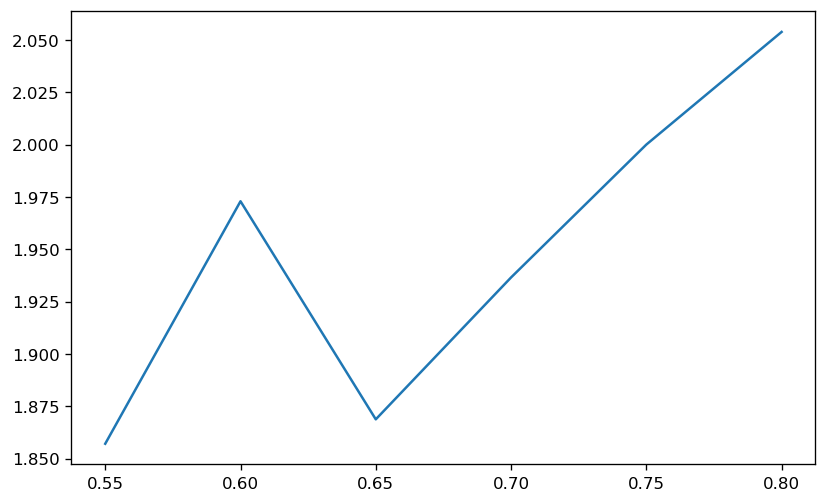

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5), dpi=120)
x = [0.55,0.6,0.65,0.7,0.75,0.8]
plt.plot(x,tuning)

plt.show()

In [254]:
print(RStune)
print(RStuneA)

print(sp0)
print(sp0A)
print(rsrsAW)
print(rsrsAA)
print(PLOTRSA)

# PWnb = [1.0, 1.0, 0.94, 0.29, 0.04]    # [1.0, 1.0, 1.0, 0.1, 0.4]

# AWb = [1.0, 1.0, 1.0, 0.96, 0.97]
# AWnb = [0.5, 0.4, 0.4, 0.13333333333333333, 0.26666666666666666]
# # [0.43333333333333335, 0.16666666666666666, 0.4666666666666667, 0.1, 0.13333333333333333]
# #[0.03333333333333333, 0.06666666666666667, 0.03333333333333333, 0.03333333333333333, 0.0]
# # [0.1, 0.09, 0.02, 0.02, 0.02]
# #[0.43333333333333335, 0.3333333333333333, 0.23333333333333334, 0.1, 0.03333333333333333]

[1.4705882352941178]
[1.153846153846154]
[1.0, 1.0, 0.6, 0.3, 0.5]
[0.9, 0.7, 0.7, 0.8, 0.8]
0.7
0.0055
31


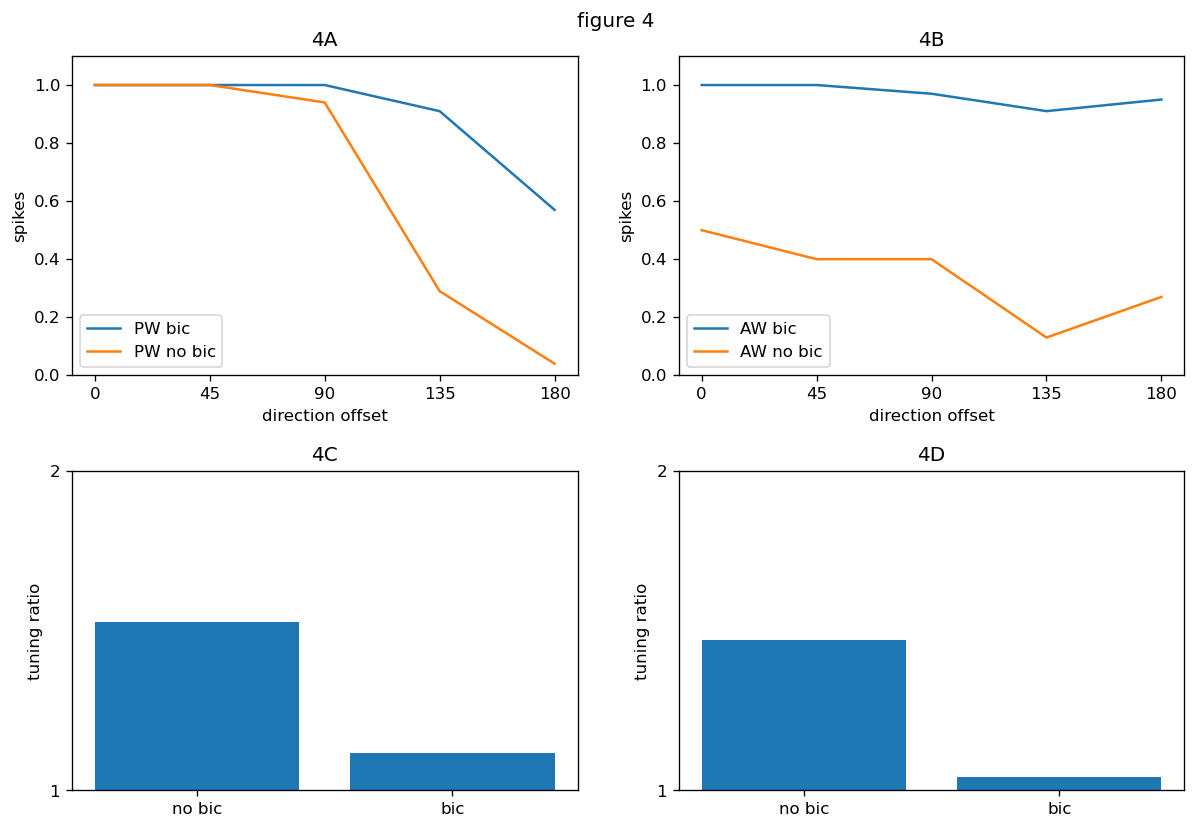

In [243]:
import matplotlib.pyplot as plt

# for a good time check nb next

direction = [0,45,90,135,180]
velocity = [1,0.8,0.67,0.5,0.4,0.33]

fig, ax = plt.subplots(2,2,dpi=120,figsize = (10,7))
fig.suptitle('figure 4')
fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.2)

PWb = [1.0, 1.0, 1.0, 0.91, 0.57]
PWnb = [1.0, 1.0, 0.94, 0.29, 0.04]

AWb = [1.0, 1.0, 0.97, 0.91, 0.95]
AWnb = [0.5, 0.4, 0.4, 0.13, 0.27]

ax[0,0].plot(direction, PWb, label = 'PW bic')
ax[0,0].plot(direction, PWnb, label = 'PW no bic')
ax[0,0].set_xticks([0,45,90,135,180])
ax[0,0].set_ylim([0,1.1])
ax[0,0].legend()

ax[0,1].plot(direction, AWb, label = 'AW bic')
ax[0,1].plot(direction, AWnb, label = 'AW no bic')
ax[0,1].set_ylim([0,1.1])
ax[0,1].set_xticks([0,45,90,135,180])
ax[0,1].legend()

x = ['no bic','bic']

AWtuneb = 1.040567951318458424 #1.1937027021217272
AWtunenb = 1.4705882352941175 # 1.794871794871795 #2.0000000000000004 #1.9117647058823526
PWtuneb = 1.1157674686512953
PWtunenb = 1.528055055352441      # 1.4324408944167577

y1 = [PWtunenb,PWtuneb]
y2 = [AWtunenb,AWtuneb]

# y1 = [1.471625713543579,RStune]
# y2 = [1.370916995638725,RStuneA]

ax[1,0].bar(x,y1)
ax[1,1].bar(x,y2)

ax[1,0].set_yticks([1,2])
ax[1,1].set_yticks([1,2])

ax[1,0].set_ylim([1,2])
ax[1,1].set_ylim([1,2])

ax[1,0].set_title('PW')
ax[1,1].set_title('AW')

ax[0,0].set_title('4A')
ax[0,1].set_title('4B')
ax[1,0].set_title('4C')
ax[1,1].set_title('4D')

plt.setp(ax[0,:], ylabel='spikes')
plt.setp(ax[1,:], ylabel='tuning ratio')
plt.setp(ax[0,:], xlabel='direction offset')

plt.show()

In [3]:
# initialize storage arrays
coupling  = np.zeros((tcells,tcells),dtype=int)     # array of T/F of synapses
couplingA = np.zeros((tcells,tcells),dtype=int)
couplingC = np.zeros((tcells,tcells),dtype=int)
tctimes   = np.zeros((tTC))                         # store spike times of each TC cell
tctimesA  = np.zeros((tTC))
time      = np.zeros((ASIZE,))

fsvolt  = np.zeros((numFS,ASIZE))
fsexc   = np.zeros((numFS,ASIZE))
fsinh   = np.zeros((numFS,ASIZE))         
rsvolt  = np.zeros((tRS,ASIZE))
rsinh   = np.zeros((tRS,ASIZE))
rsexc   = np.zeros((tRS,ASIZE))
tcrsexc = np.zeros((tRS,ASIZE))
rsrsexc = np.zeros((tRS,ASIZE))

fsvoltA  = np.zeros((numFS,ASIZE))
fsexcA   = np.zeros((numFS,ASIZE))
fsinhA   = np.zeros((numFS,ASIZE))         
rsvoltA  = np.zeros((tRS,ASIZE))
rsinhA   = np.zeros((tRS,ASIZE))
rsexcA   = np.zeros((tRS,ASIZE))
tcrsexcA = np.zeros((tRS,ASIZE))
rsrsexcA = np.zeros((tRS,ASIZE))

# temporary storage variables (V, exc, inh) 
fsv   = np.zeros((numFS,2))
fse   = np.zeros((numFS,2))
fsi   = np.zeros((numFS,2))
rsv   = np.zeros((tRS,2))
rsi   = np.zeros((tRS,2))
rse   = np.zeros((tRS,2))
tcrse = np.zeros((tRS,2))
rsrse = np.zeros((tRS,2))

# temporary storage variables (V, exc, inh) for 2nd barrel
fsvA   = np.zeros((numFS,2))
fseA   = np.zeros((numFS,2))
fsiA   = np.zeros((numFS,2))
rsvA   = np.zeros((tRS,2))
rsiA   = np.zeros((tRS,2))
rseA   = np.zeros((tRS,2))       # rscross
tcrseA = np.zeros((tRS,2))
rsrseA = np.zeros((tRS,2))

# track refractory periods for each neuron
fsref = np.zeros((numFS,))
rsref = np.zeros((tRS,))
fsrefA = np.zeros((numFS,))
rsrefA = np.zeros((tRS,))

# track of spike counts of each neuron (all trials)
fsspikecount  = np.zeros((trials,numFS),dtype=int)
rsspikecount  = np.zeros((trials,tRS),dtype=int)

fsspikecountA  = np.zeros((trials,numFS),dtype=int)
rsspikecountA  = np.zeros((trials,tRS),dtype=int)  

# keep track of how many spikes have been inputed
fsspiketrack  = np.zeros((numFS,),dtype=int)
fsspiketrack2 = np.zeros((numFS,),dtype=int) 
rsspiketrack  = np.zeros((tRS,),dtype=int) 

fsspiketrackA  = np.zeros((numFS,),dtype=int)
fsspiketrack2A = np.zeros((numFS,),dtype=int) 
rsspiketrackA  = np.zeros((tRS,),dtype=int) 

# track spike times of each neuron (all trials)
fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

# 
tempexc = np.zeros((ASIZE,))
tempinh = np.zeros((ASIZE,))
tempsyn = np.zeros((ASIZE,))

tempexcA = np.zeros((ASIZE,))
tempinhA = np.zeros((ASIZE,))
tempsynA = np.zeros((ASIZE,))

In [4]:
def SetCoupling(coupling,seed):
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < tcfsP
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = np.random.uniform(0,1) < fsfsP
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    if diff == 0: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs0
                    if diff == 1: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs1
                    if diff == 2: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs2
                    if diff == 3: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs3
                    if diff == 4: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs4
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < fsrsP
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsP
                        
def CrossCoupling(coupling,seed): 
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < tcfsP
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = np.random.uniform(0,1) < fsfsP
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    if diff == 0: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs0
                    if diff == 1: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs1
                    if diff == 2: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs2
                    if diff == 3: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs3
                    if diff == 4: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs4
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < rsfsAW
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsAW

import scipy as sp

def IGDraw(mu,lmbda):
    np.random.seed()
#     mu=TCmean
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    v=np.random.normal()
    y=v*v
    x=mu + (mu*mu*y)/(2.0*lmbda) - (mu/(2.0*lmbda))*math.sqrt(4.0*mu*lmbda*y + mu*mu*y*y)
    z=np.random.uniform(0,1)
    temp=(mu*mu)/x
    if (z<=(mu/(mu+x))):
        temp=x
    return temp

def setTCspike(tctimes,defdir,TCmu): 
    np.random.seed()
    mu=TCmu
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    
    for i in range(numTC*(defdir-1)+1,numTC*(defdir-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp0: 
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+1 <= numdir:
        group = defdir+1
    else:
        group = 1
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-1 >= 1:
        group = defdir-1
    else:
        group = numdir
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+2 <= numdir:
        group = defdir+2
    else:
        group = 2-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-2 >= 1:
        group = defdir-2
    else:
        group = numdir-(2-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+3 <= numdir:
        group = defdir+3
    else:
        group = 3-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-3 >= 1:
        group = defdir-3
    else:
        group = numdir-(3-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+4 <= numdir:
        group = defdir+4
    else: 
        group = defdir-4
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1]=-1.0
        if np.random.uniform(0,1) < tcsp4:
            tctimes[i-1] = IGDraw(mu,lmbda)